In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json



import random
import time
from pathlib import Path
from os import path
import os, sys
from typing import Optional

from util.logger import setup_logger

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import torch.distributed as dist

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from util.utils import clean_state_dict

import matplotlib.pyplot as plt
import torchvision

In [2]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [4]:
from argparse import Namespace
args = Namespace(config_file='config/DINO/DINO_4scale.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0}, dataset_file='coco', coco_path='/home/maksimgaiduk/repos/datasets/coco_original', coco_panoptic_path=None, remove_difficult=False, fix_size=False, output_dir='logs/DINO/R50-MS4', note='', device='cuda', seed=42, resume='', pretrain_model_path=None, finetune_ignore=None, start_epoch=0, eval=False, num_workers=10, test=False, debug=False, find_unused_params=False, save_results=False, save_log=False, world_size=1, dist_url='env://', rank=0, local_rank=0, amp=False, distributed=False, data_aug_scales=[480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800], data_aug_max_size=1333, data_aug_scales2_resize=[400, 500, 600], data_aug_scales2_crop=[384, 600], data_aug_scale_overlap=None, num_classes=91, lr=0.0001, param_dict_type='default', lr_backbone=1e-05, lr_backbone_names=['backbone.0'], lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, ddetr_lr_param=False, batch_size=2, weight_decay=0.0001, epochs=12, lr_drop=11, save_checkpoint_interval=1, clip_max_norm=0.1, onecyclelr=False, multi_step_lr=False, lr_drop_list=[33, 45], modelname='dino', frozen_weights=None, backbone='resnet50', use_checkpoint=False, dilation=False, position_embedding='sine', pe_temperatureH=20, pe_temperatureW=20, return_interm_indices=[1, 2, 3], backbone_freeze_keywords=None, enc_layers=6, dec_layers=6, unic_layers=0, pre_norm=False, dim_feedforward=2048, hidden_dim=256, dropout=0.0, nheads=8, num_queries=900, query_dim=4, num_patterns=0, pdetr3_bbox_embed_diff_each_layer=False, pdetr3_refHW=-1, random_refpoints_xy=False, fix_refpoints_hw=-1, dabdetr_yolo_like_anchor_update=False, dabdetr_deformable_encoder=False, dabdetr_deformable_decoder=False, use_deformable_box_attn=False, box_attn_type='roi_align', dec_layer_number=None, num_feature_levels=4, enc_n_points=4, dec_n_points=4, decoder_layer_noise=False, dln_xy_noise=0.2, dln_hw_noise=0.2, add_channel_attention=False, add_pos_value=False, two_stage_type='standard', two_stage_pat_embed=0, two_stage_add_query_num=0, two_stage_bbox_embed_share=False, two_stage_class_embed_share=False, two_stage_learn_wh=False, two_stage_default_hw=0.05, two_stage_keep_all_tokens=False, num_select=300, transformer_activation='relu', batch_norm_type='FrozenBatchNorm2d', masks=False, aux_loss=True, set_cost_class=2.0, set_cost_bbox=5.0, set_cost_giou=2.0, cls_loss_coef=1.0, mask_loss_coef=1.0, dice_loss_coef=1.0, bbox_loss_coef=5.0, giou_loss_coef=2.0, enc_loss_coef=1.0, interm_loss_coef=1.0, no_interm_box_loss=False, focal_alpha=0.25, decoder_sa_type='sa', matcher_type='HungarianMatcher', decoder_module_seq=['sa', 'ca', 'ffn'], nms_iou_threshold=-1, dec_pred_bbox_embed_share=True, dec_pred_class_embed_share=True, use_dn=True, dn_number=100, dn_box_noise_scale=1.0, dn_label_noise_ratio=0.5, embed_init_tgt=True, dn_labelbook_size=91, match_unstable_error=True, use_ema=False, ema_decay=0.9997, ema_epoch=0, use_detached_boxes_dec_out=False, dn_scalar=100, dn_label_coef=1.0, dn_bbox_coef=1.0)

In [5]:
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
dataset_train = build_dataset(image_set='train', args=args)

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...


Done (t=16.41s)
creating index...
index created!


In [7]:
print(len(dataset_train[0]))
print(dataset_train[0][0].shape)
print(dataset_train[1][0].shape)
dataset_train[0][1]

2
torch.Size([3, 512, 682])
torch.Size([3, 480, 646])


{'boxes': tensor([[0.5205, 0.6888, 0.9556, 0.5955],
         [0.2635, 0.2472, 0.4989, 0.4764],
         [0.3629, 0.7329, 0.4941, 0.5106],
         [0.6606, 0.4189, 0.6789, 0.7815],
         [0.3532, 0.1326, 0.1180, 0.0969],
         [0.2269, 0.1298, 0.0907, 0.0972],
         [0.3317, 0.2269, 0.1313, 0.1469],
         [0.3571, 0.0792, 0.1481, 0.1481]]),
 'labels': tensor([51, 51, 56, 51, 55, 55, 55, 55]),
 'image_id': tensor([9]),
 'area': tensor([282171.7812, 104435.5469, 116523.6641,  57095.6250,   5263.0371,
           3898.9131,   8482.9902,   6992.8281]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([736, 981])}

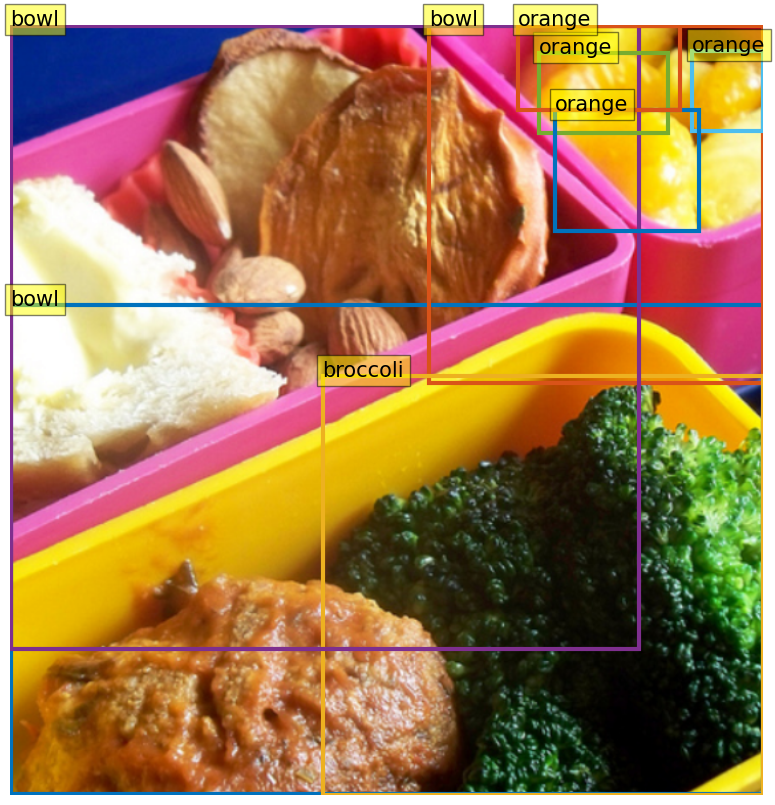

In [8]:
example = dataset_train[0]
plot_results(example[0], example[1]["labels"], example[1]["boxes"])

In [9]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, num_workers=args.num_workers)

In [10]:
i = 0
for samples, targets in data_loader_train:
    i += 1
    if i > 2:
        break
samples.tensors.shape

torch.Size([2, 3, 861, 1007])

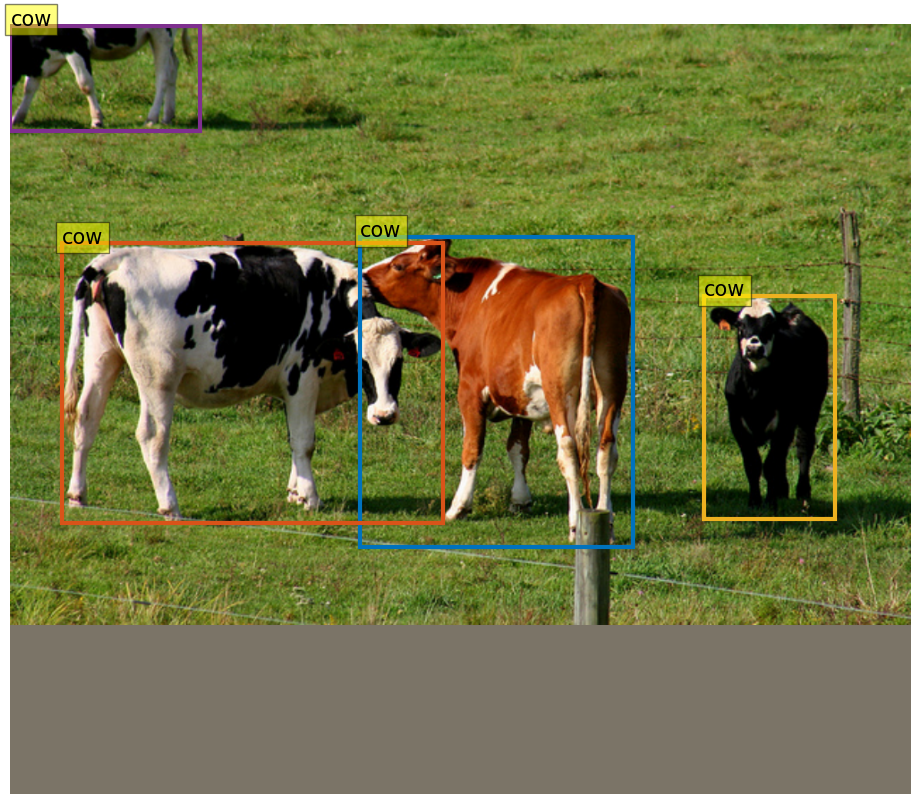

In [11]:
plot_results(samples.tensors[0], targets[0]["labels"], targets[0]["boxes"], mask=samples.mask[0])

In [12]:
def build_model_main(args):
    # we use register to maintain models from catdet6 on.
    from models.registry import MODULE_BUILD_FUNCS
    assert args.modelname in MODULE_BUILD_FUNCS._module_dict
    build_func = MODULE_BUILD_FUNCS.get(args.modelname)
    model, criterion, postprocessors = build_func(args)
    return model, criterion, postprocessors

model, criterion, postprocessors = build_model_main(args)

/opt/conda/envs/dino/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/dino/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/dino/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device = "cuda"
model = model.to(device)

In [14]:
samples = samples.to(device)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [15]:
outputs = model(samples, targets)
outputs

/opt/conda/envs/dino/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'pred_logits': tensor([[[-4.5601, -4.0224, -4.7521,  ..., -4.9359, -5.7524, -4.9860],
          [-4.5894, -4.3289, -4.4718,  ..., -4.9389, -5.8631, -4.8989],
          [-4.6359, -4.1260, -4.6789,  ..., -4.9296, -5.7617, -5.0858],
          ...,
          [-4.1726, -4.4414, -4.4932,  ..., -4.7966, -5.8510, -4.8384],
          [-4.3326, -4.4949, -4.7312,  ..., -4.9807, -5.8924, -4.9224],
          [-4.5982, -4.2677, -4.4892,  ..., -4.8767, -5.6250, -4.7117]],
 
         [[-4.4975, -4.1039, -3.7288,  ..., -4.0563, -5.4781, -5.4547],
          [-4.6014, -4.5042, -3.7219,  ..., -4.0644, -5.1576, -5.9085],
          [-4.4253, -4.2262, -4.3171,  ..., -4.2035, -5.3169, -5.3657],
          ...,
          [-4.9694, -4.2512, -3.9513,  ..., -4.1789, -5.7477, -5.0523],
          [-4.6411, -4.1619, -3.9655,  ..., -4.4321, -5.2514, -5.2530],
          [-4.3436, -4.6609, -4.2996,  ..., -4.0740, -5.8402, -5.6168]]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 'pred_boxes': tensor([[[0.1151, 

In [16]:
loss_dict = criterion(outputs, targets)

/home/maksimgaiduk/repos/DINO/models/dino/dino.py:512: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t = torch.range(0, len(targets[i]['labels']) - 1).long().cuda()
